# Trabajo Práctico 1: Propiedades en Venta - XGBOOST

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

## Dependencias

In [176]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

#modelos y métricas
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Carga de datos y preprocesamiento

### Carga de datos

Fijo una semilla.

In [177]:
semilla = 137

Cargo los datos de los avisos con tipo de precio.

In [178]:
df = pd.read_csv("https://drive.usercontent.google.com/u/1/uc?id=1Aib-aBN7wcI3EuPTX-Kd7VyZVwffB_sQ&export=download",
                 index_col=0)

### Encoding

Hago OneHot encoding para el tipo de propiedad.

In [179]:
# OneHot encoding para tipo de propiedad
df = pd.get_dummies(df, columns=["property_type"], drop_first=True)

Encodeo con LabelEncoder los barrios, y no opto por OneHot para esta variable por la cantidad de columnas que se generarian al encodear de esa forma los barrios

In [180]:
# OneHot encoding para barrio
df = pd.get_dummies(df, columns=["neighbourhood"], drop_first=True)

### Selección de features

No uso `property_price` porque es el target de la regresión, así como tampoco utilizo `tipo_precio` para tener un primer acercamiento a las predicciones del precio sin esta información. Otras variables irrelevantes para el analisis son `id` y `property_title`, por ser estas variables particulares de cada aviso y sin relación con el target.

In [181]:
onehot_barrios = [col for col in df.columns if col.startswith(("neighbourhood_"))]

features = ['property_rooms',
            'property_bedrooms',
            'property_surface_total',
            'property_surface_covered',
            'latitud',
            'longitud',
            'property_type_Departamento',
            'property_type_PH',
            ]

features = features + onehot_barrios

target = ['property_price']

Genero dos dataframes, uno para nuestro x (features), y otro para nuestro y (target a predecir).

In [182]:
df_x = df[features]
df_y = df[target]

## Generación de conjuntos de train y test

Genero los conjuntos de train (80%) y test (20%), estratificando mediante el tipo de precio para generar conjuntos balanceados.

In [183]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, stratify=df['tipo_precio'].values, random_state=semilla)

## Entrenamiento de modelos

### Entrenamiento de un modelo con parametros por defecto

Pruebo entrenar un modelo de XGBoost con parámetros por defecto.

In [184]:
xgb_model = xgboost.XGBRegressor()

Entreno el modelo con los datos de entrenamiento.

In [185]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Realizo las predicciones con el modelo de regresion entrenado

In [186]:
y_pred = xgb_model.predict(X_test)

Veamos ahora los híperparametros del modelo.

In [187]:
xgb_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

Score R2 del modelo para train.

In [188]:
train_score = xgb_model.score(X_train, y_train)

print("R2 en train: ", train_score)

R2 en train:  0.9023400681347367


Métricas del modelo en testing.

In [189]:
rmse = np.sqrt(MSE(y_test, y_pred))
mse = MSE(y_test, y_pred)
r2 = R2(y_test, y_pred)

print("RMSE: % f" %(rmse))
print("MSE: % f" %(mse))
print("R2: % f" %(r2))

RMSE:  50766.321820
MSE:  2577219431.179746
R2:  0.854338


## Entrenamiento con kfold cross validation

Antes de pasar a entrenar todos los modelos, hay que aclarar que como existen distintos tipos de boosters, se opta por entrenar por separado 2 tipos de boosters (`gblinear` y `gbtree`) y obtener el mejor modelo para cada uno de ellos, ya que hay parametros que parecen diferir en cada tipo de booster.

### Entrenamiento de un booster linear

Optimizo los híperparametros de un modelo de XGBoost con un booster linear haciendo 10 iteraciones de random search con 5 folds.

Los híperparametros que se buscan optimizar son:
- `objective`: Indica el objetivo de aprendizaje de la regresión. Puede ser linear, error al caudrado o error absoluto.
- `eval_metric`: Metrica de evaluación para los datos de validación.
- `learning_rate`: Paso utilizado para la reducción de los pesos. A menor valor, más conservativo será el modelo. Se aplica luego de cada paso de boost y prevee overfitting. Rango: [0, 1]
- `lambda`: parametro de regularizacion L1.
- `alpha`: parametro de regularizacion L2.
- `gamma`: parametro de poda.

In [190]:
n = 10
folds = 5

params_grid = {"booster": ["gblinear"],
               "objective": ["reg:linear", "reg:squarederror", "reg:absoluteerror"],
               "eval_metric": ["rmse", "mae"],
               "learning_rate": np.linspace(0, 1, 200),
               "gamma": np.linspace(0, 100, 300),
               "lambda": np.linspace(0, 1),
               "alpha": np.linspace(0, 1)
               }

kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=semilla)

xgb_base = xgboost.XGBRegressor()

randomcv = RandomizedSearchCV(estimator=xgb_base,
                              param_distributions=params_grid,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=137, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importan...
       0.87939698, 0.88442211, 0.88944724, 0.89447236, 0.89949749,
       0.90452261, 0.90954774, 0.91457286, 0.91959799, 0.92462312,
       0.92964824, 0.93467337, 0.93969849, 0.94472362, 0.94974874,
       0.95477387, 0.95979899, 0.96482412, 0.96984925, 0.97487437,
       0.9798995 , 0.98492462, 0.98994975, 0.99497487, 1.        ]),
                                        'objective': ['reg:linear',
                                                      'reg:squarederror',
                                                      'reg:absoluteerror']},
                   random_state=137)

Veo los mejores parámetros y se observa que eligio un learning rate de 0,5 aproximadamente, y cómo objetivo el `squarederror` o error cuadrático. También noto que se eligio el MAE como métrica para validación.

In [191]:
print(randomcv.best_params_)

{'objective': 'reg:squarederror', 'learning_rate': 0.9547738693467337, 'lambda': 0.16326530612244897, 'gamma': 51.83946488294314, 'eval_metric': 'mae', 'booster': 'gblinear', 'alpha': 0.6530612244897959}


Guardo el mejor estimador con booster linear.

In [192]:
mejor_linear = xgboost.XGBRegressor()
mejor_linear.set_params(**randomcv.best_params_)

mejor_linear.fit(X_train, y_train)

XGBRegressor(alpha=0.6530612244897959, base_score=None, booster='gblinear',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=51.83946488294314, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.16326530612244897,
             learning_rate=0.9547738693467337, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, ...)

Realizo las predicciones

In [193]:
y_pred_linear = mejor_linear.predict(X_test)

Obtengo los puntajes R2 de cross validation del modelo.

In [194]:
scores = cross_val_score(mejor_linear, X_train, y_train, cv=kfoldcv)

Ahora vemos todos los puntajes R2 para train y en cross validation. El método de XGBoost `score` siempre nos devuelve el puntaje de R2.

In [195]:
train_score = mejor_linear.score(X_train, y_train)

print("Cross val R2 scores: ", scores)
print("R2 sobre train: ", train_score)

Cross val R2 scores:  [0.64008955 0.63020155 0.64143328 0.63497423 0.64575404]
R2 sobre train:  0.6385129054974235


Ahora muestro el RMSE, MSE y R2 sobre el conjunto de test.

In [196]:
rmse_linear = np.sqrt(MSE(y_test, y_pred_linear))
mse_linear = MSE(y_test, y_pred_linear)
r2_linear = R2(y_test, y_pred_linear)

print("RMSE: % f" %(rmse_linear))
print("MSE: % f" %(mse_linear))
print("R2: % f" %(r2_linear))

RMSE:  80104.087939
MSE:  6416664904.593136
R2:  0.637335


### Entrenamiento de un booster arbol

Pruebo optimizar un modelo XGBoost utilizando como booster un arbol, haciendo 10 iteraciones de random search con 5 folds, y optimizando los siguientes híperparametros:
- `objective`: Indica el objetivo de aprendizaje de la regresión. Puede ser linear, error al caudrado o error absoluto.
- `eval_metric`: Metrica de evaluación para los datos de validación.
- `learning_rate`: Paso utilizado para la reducción de los pesos. A menor valor, más conservativo será el modelo. Se aplica luego de cada paso de boost y prevee overfitting. Rango: [0, 1]
- `min_split_loss`: Minima reducción de loss requerida para hacer una partición de un nodo hoja del árbol. A mayor valor, sera más conservativo (rango de 0 a +inf).
- `max_depth`: Mayor profundidad de un árbol.
- `lambda`: parametro de regularizacion L1.
- `alpha`: parametro de regularizacion L2.
- `gamma`: parametro de poda.

In [197]:
n = 10
folds = 5

params_grid = {"booster": ["gbtree"],
               "objective": ["reg:linear", "reg:squarederror", "reg:absoluteerror"],
               "eval_metric": ["rmse", "mae"],
               "learning_rate": np.linspace(0, 1, 200),
               "gamma": np.linspace(0, 100, 300),
               "max_depth": list(range(1, 20)),
               "lambda": np.linspace(0, 1),
               "alpha": np.linspace(0, 1)
               }

kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=semilla)

xgb_base = xgboost.XGBRegressor()

randomcv = RandomizedSearchCV(estimator=xgb_base,
                              param_distributions=params_grid,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=137, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importan...
       0.90452261, 0.90954774, 0.91457286, 0.91959799, 0.92462312,
       0.92964824, 0.93467337, 0.93969849, 0.94472362, 0.94974874,
       0.95477387, 0.95979899, 0.96482412, 0.96984925, 0.97487437,
       0.9798995 , 0.98492462, 0.98994975, 0.99497487, 1.        ]),
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'objective': ['reg:linear',
                                                      'reg:squarederror',
                                                      'reg:absoluteerror']},
                   random_state=137)

Entreno el modelo con los mejores híperparametros que se encontraron mediante random search.

In [198]:
mejor_arbol = xgboost.XGBRegressor()
mejor_arbol.set_params(**randomcv.best_params_)

mejor_arbol.fit(X_train, y_train)

XGBRegressor(alpha=0.3469387755102041, base_score=None, booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=91.30434782608695, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.8775510204081632,
             learning_rate=0.6180904522613065, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, ...)

Hago las predicciones.

In [199]:
y_pred_arbol = mejor_arbol.predict(X_test)

Guardo los puntajes R2 de cross validation.

In [200]:
scores = cross_val_score(mejor_arbol, X_train, y_train, cv=kfoldcv)

Muestro los mejores híperparametros del mejor árbol.

In [201]:
print(randomcv.best_params_)

{'objective': 'reg:squarederror', 'max_depth': 14, 'learning_rate': 0.6180904522613065, 'lambda': 0.8775510204081632, 'gamma': 91.30434782608695, 'eval_metric': 'mae', 'booster': 'gbtree', 'alpha': 0.3469387755102041}


Ahora observamos los puntajes R2 de cross validation de random search y se puede observar que se obtuvieron mejores scores y un mejor estimador con un tree booster.

In [202]:
train_score = mejor_arbol.score(X_train, y_train)

print("R2 train: ", train_score)
print("Cross val R2 scores: ", scores)

R2 train:  0.9949407040585045
Cross val R2 scores:  [0.86963458 0.8667845  0.87147699 0.875446   0.85705143]


Metricas (RMSE, MSE, R2) sobre el conjunto de test.

In [203]:
rmse_arbol = np.sqrt(MSE(y_test, y_pred_arbol))
mse_arbol = MSE(y_test, y_pred_arbol)
r2_arbol = R2(y_test, y_pred_arbol)

print("RMSE: % f" %(rmse_arbol))
print("MSE: % f" %(mse_arbol))
print("R2: % f" %(r2_arbol))

RMSE:  48864.468349
MSE:  2387736267.051718
R2:  0.865047


De esto último puede concluirse que el modelo parece estar teniendo Overfitting, ya que en test la métrica está al rededor de 10 puntos por debajo, teniendo un score R2 casi perfecto para train.

## Entrenamiento escalando datos

### Escalado de datos

Para este siguiente entrenamiento, buscamos escalar los datos de superficies, latitud y longitud mediante un escalador estándar, a modo de ver que impacto tienen estas variables a la hora de predecir el precio.

In [204]:
df_escalado = df.copy()

Escalo latitud y longitud.

In [205]:
std_scaler = StandardScaler()

std_scaler.fit(pd.DataFrame(df_escalado['property_surface_total']).to_numpy())

df_escalado['latitud'] = std_scaler.transform(pd.DataFrame(df_escalado['latitud']).to_numpy())

In [206]:
std_scaler = StandardScaler()

std_scaler.fit(pd.DataFrame(df_escalado['longitud']).to_numpy())

df_escalado['longitud'] = std_scaler.transform(pd.DataFrame(df_escalado['longitud']).to_numpy())

Escalo las superficies.

In [207]:
std_scaler = StandardScaler()

std_scaler.fit(pd.DataFrame(df_escalado['property_surface_total']).to_numpy())

df_escalado['property_surface_total'] = std_scaler.transform(pd.DataFrame(df_escalado['property_surface_total']).to_numpy())

In [208]:
std_scaler = StandardScaler()

std_scaler.fit(pd.DataFrame(df_escalado['property_surface_covered']).to_numpy())

df_escalado['property_surface_covered'] = std_scaler.transform(pd.DataFrame(df_escalado['property_surface_covered']).to_numpy())

Genero los dataframes de x (features) e y (targets).

In [209]:
df_escalado_x = df_escalado[features]
df_escalado_y = df_escalado[target]

### Generación de nuevos conjuntos de train y test

Genero los conjuntos de train y test de la misma forma que antes.

In [210]:
X_train, X_test, y_train, y_test = train_test_split(df_escalado_x, df_escalado_y, test_size=0.20, stratify=df_escalado['tipo_precio'].values, random_state=semilla)

### Entrenamiento de un booster linear

Hago random search para encontrar los mejores híperparametros en 10 iteraciones con 5 folds de cross validation.

In [211]:
n = 10
folds = 5

params_grid = {"booster": ["gblinear"],
               "objective": ["reg:linear", "reg:squarederror", "reg:absoluteerror"],
               "eval_metric": ["rmse", "mae"],
               "learning_rate": np.linspace(0, 1, 200),
               "gamma": np.linspace(0, 100, 300),
               "lambda": np.linspace(0, 1),
               "alpha": np.linspace(0, 1)
               }

kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=semilla)

xgb_base = xgboost.XGBRegressor()

randomcv = RandomizedSearchCV(estimator=xgb_base,
                              param_distributions=params_grid,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=137, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importan...
       0.87939698, 0.88442211, 0.88944724, 0.89447236, 0.89949749,
       0.90452261, 0.90954774, 0.91457286, 0.91959799, 0.92462312,
       0.92964824, 0.93467337, 0.93969849, 0.94472362, 0.94974874,
       0.95477387, 0.95979899, 0.96482412, 0.96984925, 0.97487437,
       0.9798995 , 0.98492462, 0.98994975, 0.99497487, 1.        ]),
                                        'objective': ['reg:linear',
                                                      'reg:squarederror',
                                                      'reg:absoluteerror']},
                   random_state=137)

Veo los mejores híperparametros y entreno el estimador con los híperparametros encontrados.

In [212]:
mejor_linear_escalado = xgboost.XGBRegressor()
mejor_linear_escalado.set_params(**randomcv.best_params_)

mejor_linear_escalado.fit(X_train, y_train)

print("Híperparametros: ", randomcv.best_params_)

Híperparametros:  {'objective': 'reg:squarederror', 'learning_rate': 0.9547738693467337, 'lambda': 0.16326530612244897, 'gamma': 51.83946488294314, 'eval_metric': 'mae', 'booster': 'gblinear', 'alpha': 0.6530612244897959}


Hago las predicciones nuevamente.

In [213]:
y_pred_linear_escalado = mejor_linear_escalado.predict(X_test)

Ahora veo los scores de R2 del modelo en train y cross validation y puedo observar que se producen cambios ligeros en las mismas.

In [214]:
scores = cross_val_score(mejor_linear_escalado, X_train, y_train, cv=kfoldcv)
train_score = mejor_linear_escalado.score(X_train, y_train)

print("R2 train: ", train_score)
print("Cross val R2 scores: ", scores)

R2 train:  0.6227730162402785
Cross val R2 scores:  [0.62407045 0.61235911 0.62850865 0.61955286 0.6295016 ]


Muestro las metricas (RMSE, MSE, R2) sobre el conjunto de test.

In [215]:
rmse_linear_escalado = np.sqrt(MSE(y_test, y_pred_linear_escalado))
mse_linear_escalado = MSE(y_test, y_pred_linear_escalado)
r2_linear_escalado = R2(y_test, y_pred_linear_escalado)

print("RMSE: % f" %(rmse_linear_escalado))
print("MSE: % f" %(mse_linear_escalado))
print("R2: % f" %(r2_linear_escalado))

RMSE:  81709.075616
MSE:  6676373037.958066
R2:  0.622657


Para estas últimas también hay ligeras mejorías pero no llegan a ser muy significativas.

### Entrenamiento de un booster arbol

Hago random search para encontrar los mejores híperparametros en 10 iteraciones con 5 folds de cross validation.

In [216]:
n = 10
folds = 5

params_grid = {"booster": ["gbtree"],
               "objective": ["reg:linear", "reg:squarederror", "reg:absoluteerror"],
               "eval_metric": ["rmse", "mae"],
               "learning_rate": np.linspace(0, 1, 200),
               "gamma": np.linspace(0, 100, 300),
               "max_depth": list(range(1, 20)),
               "lambda": np.linspace(0, 1),
               "alpha": np.linspace(0, 1)
               }

kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=semilla)

xgb_base = xgboost.XGBRegressor()

randomcv = RandomizedSearchCV(estimator=xgb_base,
                              param_distributions=params_grid,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=137, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importan...
       0.90452261, 0.90954774, 0.91457286, 0.91959799, 0.92462312,
       0.92964824, 0.93467337, 0.93969849, 0.94472362, 0.94974874,
       0.95477387, 0.95979899, 0.96482412, 0.96984925, 0.97487437,
       0.9798995 , 0.98492462, 0.98994975, 0.99497487, 1.        ]),
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'objective': ['reg:linear',
                                                      'reg:squarederror',
                                                      'reg:absoluteerror']},
                   random_state=137)

Entreno el modelo con los mejores híperparametros.

In [217]:
mejor_arbol_escalado = xgboost.XGBRegressor()
mejor_arbol_escalado.set_params(**randomcv.best_params_)

mejor_arbol_escalado.fit(X_train, y_train)

print("Híperparametros: ", randomcv.best_params_)

Híperparametros:  {'objective': 'reg:squarederror', 'max_depth': 14, 'learning_rate': 0.6180904522613065, 'lambda': 0.8775510204081632, 'gamma': 91.30434782608695, 'eval_metric': 'mae', 'booster': 'gbtree', 'alpha': 0.3469387755102041}


Hago las predicciones.

In [218]:
y_pred_arbol_escalado = mejor_arbol_escalado.predict(X_test)

Muestro los puntajes de R2.

In [219]:
scores = cross_val_score(mejor_arbol_escalado, X_train, y_train, cv=kfoldcv)
train_score = mejor_arbol_escalado.score(X_train, y_train)

print("R2 train: ", train_score)
print("Cross val R2 scores: ", scores)

R2 train:  0.9949783864908865
Cross val R2 scores:  [0.87581267 0.86225026 0.87644002 0.87487281 0.86242779]


Muestro las métricas en testing.

In [220]:
rmse_arbol_escalado = np.sqrt(MSE(y_test, y_pred_arbol_escalado))
mse_arbol_escalado = MSE(y_test, y_pred_arbol_escalado)
r2_arbol_escalado = R2(y_test, y_pred_arbol_escalado)

print("RMSE: % f" %(rmse_arbol_escalado))
print("MSE: % f" %(mse_arbol_escalado))
print("R2: % f" %(r2_arbol_escalado))

RMSE:  48890.887299
MSE:  2390318860.859180
R2:  0.864901


## Entrenamiento con más iteraciones

Pruebo ahora aumentar las iteraciones de random search para ver que efecto causa sobre los híperparametros que se encuentran. Realizo el mismo análisis que antes utilizando el conjunto escalado, ya que suele ser mejor tener los datos escalados sobre este modelo.

### Booster lineal

Para evitar tiempos de espera, no incluyo la celda.
Adjunto imagen de la ejecución:
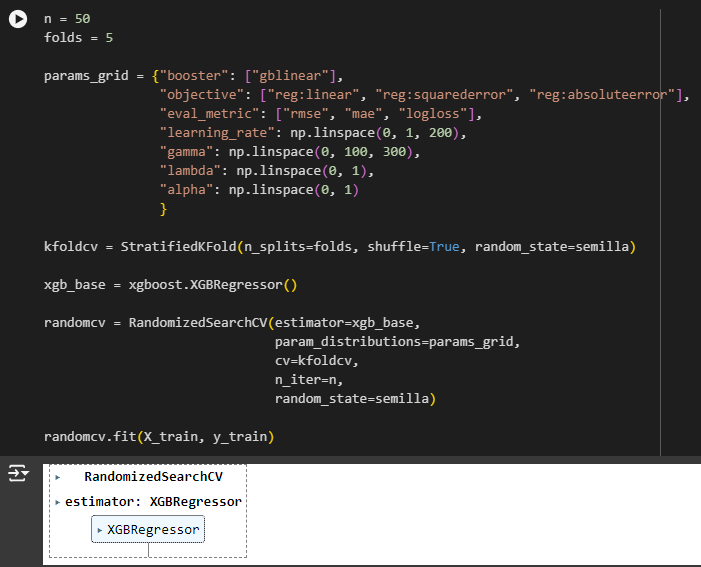

In [221]:
n = 50
folds = 5

params_grid = {"booster": ["gblinear"],
               "objective": ["reg:linear", "reg:squarederror", "reg:absoluteerror"],
               "eval_metric": ["rmse", "mae", "logloss"],
               "learning_rate": np.linspace(0, 1, 200),
               "gamma": np.linspace(0, 100, 300),
               "lambda": np.linspace(0, 1),
               "alpha": np.linspace(0, 1)
               }

kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=semilla)

xgb_base = xgboost.XGBRegressor()

randomcv = RandomizedSearchCV(estimator=xgb_base,
                              param_distributions=params_grid,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

# randomcv.fit(X_train, y_train)

In [222]:
# Dejo la grilla de parametros expresada aca para no tener que andar ejecutando random search
params_linear_50iter = {'objective': 'reg:squarederror',
          'learning_rate': 0.36180904522613067,
          'lambda': 0.0,
          'gamma': 33.11036789297659,
          'eval_metric': 'mae',
          'booster': 'gblinear',
          'alpha': 0.7959183673469387}
mejor_linear_50iter = xgboost.XGBRegressor()
mejor_linear_50iter.set_params(**params_linear_50iter)

mejor_linear_50iter.fit(X_train, y_train)

print("Híperparametros: ", params_linear_50iter)

Híperparametros:  {'objective': 'reg:squarederror', 'learning_rate': 0.36180904522613067, 'lambda': 0.0, 'gamma': 33.11036789297659, 'eval_metric': 'mae', 'booster': 'gblinear', 'alpha': 0.7959183673469387}


Hago las predicciones con el modelo entrenado.

In [223]:
y_pred_linear_50iter = mejor_linear_50iter.predict(X_test)

Se puede observar como al tener más iteraciones hubo una clara mejoria respecto al booster lineal entrenado con 10 iteraciones, si bien además se demoró más tiempo, llegando a los 12 minutos para hallar los híperparametros.

In [224]:
scores = cross_val_score(mejor_linear_50iter, X_train, y_train, cv=kfoldcv)
train_score = mejor_linear_50iter.score(X_train, y_train)

print("R2 train: ", train_score)
print("Cross val scores: ", scores)

R2 train:  0.7286701149952759
Cross val scores:  [0.73233501 0.72635297 0.72484988 0.7285625  0.72860731]


Muestro las métricas en testing y nuevamente observó que hubo una mejora en cuanto al score r2 y se redujeron tanto mae como rmse significativamente, siendo rmse la métrica que más se redujo, en aproximadamente 13000.

In [225]:
rmse_linear_50iter = np.sqrt(MSE(y_test, y_pred_linear_50iter))
mse_linear_50iter = MSE(y_test, y_pred_linear_50iter)
r2_linear_50iter = R2(y_test, y_pred_linear_50iter)

print("RMSE: % f" %(rmse_linear_50iter))
print("MSE: % f" %(mse_linear_50iter))
print("R2: % f" %(r2_linear_50iter))

RMSE:  69899.259012
MSE:  4885906410.418732
R2:  0.723852


### Booster árbol

Igual que antes, utilizo 50 iteraciones con 5 folds random search.
Adjunto imagen de la ejecucion ya que se demora unos 20 minutos:
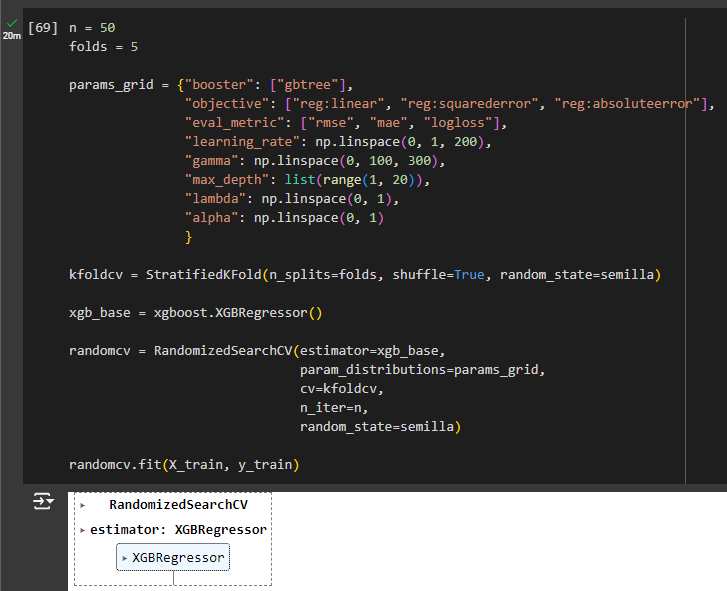

In [226]:
n = 50
folds = 5

params_grid = {"booster": ["gbtree"],
               "objective": ["reg:linear", "reg:squarederror", "reg:absoluteerror"],
               "eval_metric": ["rmse", "mae", "logloss"],
               "learning_rate": np.linspace(0, 1, 200),
               "gamma": np.linspace(0, 100, 300),
               "max_depth": list(range(1, 20)),
               "lambda": np.linspace(0, 1),
               "alpha": np.linspace(0, 1)
               }

kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=semilla)

xgb_base = xgboost.XGBRegressor()

randomcv = RandomizedSearchCV(estimator=xgb_base,
                              param_distributions=params_grid,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

# randomcv.fit(X_train, y_train)

In [227]:
# Dejo la grilla de parametros expresada aca para no tener que andar ejecutando random search
params = {'objective': 'reg:squarederror',
          'max_depth': 12,
          'learning_rate': 0.4623115577889447,
          'lambda': 0.8571428571428571,
          'gamma': 39.79933110367893,
          'eval_metric': 'rmse',
          'booster': 'gbtree',
          'alpha': 0.7959183673469387}

mejor_arbol_50iter = xgboost.XGBRegressor()
mejor_arbol_50iter.set_params(**params)

mejor_arbol_50iter.fit(X_train, y_train)

print("Híperparametros: ", params)

Híperparametros:  {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.4623115577889447, 'lambda': 0.8571428571428571, 'gamma': 39.79933110367893, 'eval_metric': 'rmse', 'booster': 'gbtree', 'alpha': 0.7959183673469387}


Hago las predicciones con el modelo entrenado.

In [228]:
y_pred_arbol_50iter = mejor_arbol_50iter.predict(X_test)

Se puede observar que el R2 en test aumento en 1 punto, mientras que en entrenamiento resulto casi igual que antes.

In [229]:
scores = cross_val_score(mejor_arbol_50iter, X_train, y_train, cv=kfoldcv)
train_score = mejor_arbol_50iter.score(X_train, y_train)

print("R2 train: ", train_score)
print("Cross val scores: ", scores)

R2 train:  0.9902683800737695
Cross val scores:  [0.88395066 0.87511287 0.88402021 0.88370564 0.87233453]


Muestro las métricas en testing.

In [230]:
rmse_arbol_50iter = np.sqrt(MSE(y_test, y_pred_arbol_50iter))
mse_arbol_50iter = MSE(y_test, y_pred_arbol_50iter)
r2_arbol_50iter = R2(y_test, y_pred_arbol_50iter)

print("RMSE: % f" %(rmse_arbol_50iter))
print("MSE: % f" %(mse_arbol_50iter))
print("R2: % f" %(r2_arbol_50iter))

RMSE:  47309.770421
MSE:  2238214377.326125
R2:  0.873498


Este modelo mejoró poco al realizar una mayor cantidad de combinaciones, ya que solo se mejoró la métrica r2 en 0.01, pero aún así resultó mejor que el modelo entrenado con 10 iteraciones.

## Entrenamiento considerando `tipo_precio`

En esta sección, y como ultima prueba, entrenamos los modelos anteriores con 10 iteraciones pero ahora incluyendo la variable que generamos, `tipo_precio`, en los features para el entrenamiento, anteriormente no la consideramos porque no es una variable que forma parte del dataset original, sino que la generamos como target para la sección de clasificación. Esto nos lleva a pensar que para futuros datos lo más probable es que no sea conocida.

De igual modo, decidimos llevar a cabo unas pruebas incluyendo esta variable para ver que cambios genera sobre los entrenamientos y predicciones.

### Encoding para la variable

Realizo OneHot encoding para la variable de `tipo_precio`

In [231]:
df_con_tipo_precio = df_escalado.copy()

In [232]:
df_con_tipo_precio = pd.get_dummies(df_con_tipo_precio, columns=["tipo_precio"], drop_first=True)

### Generación de los nuevos conjuntos de train y test

Ahora tengo que crear unos nuevos conjuntos con las features, inclyendo las columnas de onehot encoding para el tipo de precio.

In [233]:
onehot_barrios = [col for col in df_con_tipo_precio.columns if col.startswith(("neighbourhood_"))]

onehot_tipo_precio = [col for col in df_con_tipo_precio.columns if col.startswith(("tipo_precio_"))]

features = ['property_rooms',
            'property_bedrooms',
            'property_surface_total',
            'property_surface_covered',
            'latitud',
            'longitud',
            'property_type_Departamento',
            'property_type_PH',
            ]

features = features + onehot_barrios + onehot_tipo_precio

target = ['property_price']

In [234]:
df_tipo_x = df_con_tipo_precio[features]
df_tipo_y = df_con_tipo_precio[target]

Obtengo los nuevos conjuntos de train y test.

In [235]:
X_train, X_test, y_train, y_test = train_test_split(df_tipo_x, df_tipo_y, test_size=0.20, stratify=df_escalado['tipo_precio'], random_state=semilla)

### Entrenamiento de modelo con booster linear

Busco los mejores híperparametros mediante random search con 10 iteraciones y 5 folds de cross validation.

In [236]:
n = 10
folds = 5

params_grid = {"booster": ["gblinear"],
               "objective": ["reg:linear", "reg:squarederror", "reg:absoluteerror"],
               "eval_metric": ["rmse", "mae"],
               "learning_rate": np.linspace(0, 1, 200),
               "gamma": np.linspace(0, 100, 300),
               "lambda": np.linspace(0, 1),
               "alpha": np.linspace(0, 1)
               }

kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=semilla)

xgb_base = xgboost.XGBRegressor()

randomcv = RandomizedSearchCV(estimator=xgb_base,
                              param_distributions=params_grid,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=137, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importan...
       0.87939698, 0.88442211, 0.88944724, 0.89447236, 0.89949749,
       0.90452261, 0.90954774, 0.91457286, 0.91959799, 0.92462312,
       0.92964824, 0.93467337, 0.93969849, 0.94472362, 0.94974874,
       0.95477387, 0.95979899, 0.96482412, 0.96984925, 0.97487437,
       0.9798995 , 0.98492462, 0.98994975, 0.99497487, 1.        ]),
                                        'objective': ['reg:linear',
                                                      'reg:squarederror',
                                                      'reg:absoluteerror']},
                   random_state=137)

Entreno un modelo con los mejores híperparametros y los muestro.

In [237]:
mejor_linear_tipo = xgboost.XGBRegressor()
mejor_linear_tipo.set_params(**randomcv.best_params_)

mejor_linear_tipo.fit(X_train, y_train)

print("Híperparametros: ", randomcv.best_params_)

Híperparametros:  {'objective': 'reg:squarederror', 'learning_rate': 0.9547738693467337, 'lambda': 0.16326530612244897, 'gamma': 51.83946488294314, 'eval_metric': 'mae', 'booster': 'gblinear', 'alpha': 0.6530612244897959}


Hago las predicciones.

In [238]:
y_pred_linear_tipo = mejor_linear_tipo.predict(X_test)

Muestro los scores de R2 para train y cross validation.

In [239]:
scores = cross_val_score(mejor_linear_tipo, X_train, y_train, cv=kfoldcv)
train_score = mejor_linear_tipo.score(X_train, y_train)

print("R2 train: ", train_score)
print("Cross val R2 scores: ", scores)

R2 train:  0.7027002791609525
Cross val R2 scores:  [0.7029911  0.69025514 0.7106219  0.70059489 0.70940843]


Muestro las métricas en testing.

In [240]:
rmse_linear_tipo = np.sqrt(MSE(y_test, y_pred_linear_tipo))
mse_linear_tipo = MSE(y_test, y_pred_linear_tipo)
r2_linear_tipo = R2(y_test, y_pred_linear_tipo)

print("RMSE: % f" %(rmse_linear_tipo))
print("MSE: % f" %(mse_linear_tipo))
print("R2: % f" %(r2_linear_tipo))

RMSE:  72471.016547
MSE:  5252048239.410257
R2:  0.703158


Se puede ver que incluir esta variable mejoro bastante el R2 score en comparación al modelo que no la incluye, pasando de 0,63 a 0,70 en tan solo 10 iteraciones, lo cuál es similar a la mejoría obtenida con 50 iteraciones.

### Entrenamiento de modelo con booster arbol

Busco los mejores híperparametros mediante random search con 10 iteraciones y 5 folds de cross validation.

In [241]:
n = 10
folds = 5

params_grid = {"booster": ["gbtree"],
               "objective": ["reg:linear", "reg:squarederror", "reg:absoluteerror"],
               "eval_metric": ["rmse", "mae"],
               "learning_rate": np.linspace(0, 1, 200),
               "gamma": np.linspace(0, 100, 300),
               "max_depth": list(range(1, 20)),
               "lambda": np.linspace(0, 1),
               "alpha": np.linspace(0, 1)
               }

kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=semilla)

xgb_base = xgboost.XGBRegressor()

randomcv = RandomizedSearchCV(estimator=xgb_base,
                              param_distributions=params_grid,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=137, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importan...
       0.90452261, 0.90954774, 0.91457286, 0.91959799, 0.92462312,
       0.92964824, 0.93467337, 0.93969849, 0.94472362, 0.94974874,
       0.95477387, 0.95979899, 0.96482412, 0.96984925, 0.97487437,
       0.9798995 , 0.98492462, 0.98994975, 0.99497487, 1.        ]),
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'objective': ['reg:linear',
                                                      'reg:squarederror',
                                                      'reg:absoluteerror']},
                   random_state=137)

Entreno el modelo con los mejores híperparametros y los muestro.

In [242]:
mejor_arbol_tipo = xgboost.XGBRegressor()
mejor_arbol_tipo.set_params(**randomcv.best_params_)

mejor_arbol_tipo.fit(X_train, y_train)

print("Híperparametros: ", randomcv.best_params_)

Híperparametros:  {'objective': 'reg:linear', 'max_depth': 6, 'learning_rate': 0.3165829145728643, 'lambda': 0.8979591836734693, 'gamma': 94.64882943143813, 'eval_metric': 'rmse', 'booster': 'gbtree', 'alpha': 0.6326530612244897}


Hago las predicciones con el modelo entrenado.

In [243]:
y_pred_arbol_tipo = mejor_arbol_tipo.predict(X_test)

Muestro los scores R2 en train y cross validation.

In [244]:
scores = cross_val_score(mejor_arbol_tipo, X_train, y_train, cv=kfoldcv)
train_score = mejor_arbol_tipo.score(X_train, y_train)

print("R2 train: ", train_score)
print("Cross val R2 scores: ", scores)

R2 train:  0.9593885036166919
Cross val R2 scores:  [0.93666712 0.93064274 0.93660578 0.92889855 0.935049  ]


Muestro las métricas en testing.

In [245]:
rmse_arbol_tipo = np.sqrt(MSE(y_test, y_pred_arbol_tipo))
mse_arbol_tipo = MSE(y_test, y_pred_arbol_tipo)
r2_arbol_tipo = R2(y_test, y_pred_arbol_tipo)

print("RMSE: % f" %(rmse_arbol_tipo))
print("MSE: % f" %(mse_arbol_tipo))
print("R2: % f" %(r2_arbol_tipo))

RMSE:  37043.037990
MSE:  1372186663.529403
R2:  0.922445


Notamos que si bien disminuyó el score de R2 en train, pasando de 0,99 a 0,96, se incrementó el score de R2 en testing, de 0,87 a 0,92, lo cual significa que el modelo esta encontrando mejor las relaciones entre las variables para predecir el precio de una vivienda en venta que resulta ajena a los datos de entrenamiento (un registro 'desconocido' para el modelo entrenado).

## Guardado del mejor modelo

Guardo mediante joblib el mejor modelo que obtuve, el cual utiliza un booster arbol con 50 iteraciones y datos escalados sin incluir la variable `tipo_precio`. Tomamos este ya que consideramos que para nuevas observaciones lo más probable es que no vamos a contar con esta variable, ya que para conocerla debería conocerse también de antemano el precio, por lo cual no tendría sentido predecirlo.

In [246]:
import joblib

joblib.dump(mejor_arbol_50iter, "mejor_xgboost.model")

['mejor_xgboost.model']

## Conclusiones

Notamos que el modelo de xgboost utilizando booster árbol resulta tener la mejor métrica en comparación al booster lineal, sobre todo al dejarlo correr más iteraciones, si bien esto causa también mayor costo temporal. También notamos que tiende a hacer overfitting, pero con una diferencia que no resulta excesiva entre los sets de entrenamiento y de test, teniendo este un score de R2 casi perfecto, de 0,99 para entrenamiento, y un score bastante elevado para test, de 0,87. Esto nos lleva a pensar que si bien tiende al overfitting, a su vez esta tendencia no es tan excesiva como aparenta y parece encontrar relaciones buenas como para performar considerablemente bien en testing.

Por otro lado, incrementar las iteraciones al booster lineal le generó un aumento un tanto significativo de la calidad de las predicciones, aún tendiendo al underfitting, ya que su performance resulta de 0,72 (aproximadamente) tanto para los sets de test como entrenamiento, lo cual fue 0,09 mejor (aproximadamente) respecto del entrenamiento con 10 iteraciones en testing. El costo temporal fue mayor, pasando de 2 minutos a 12 en obtener un 0,09 de aumento únicamente.

Por último, notamos que escalar los datos realmente no genera una mejora significativa en la performance de los modelos, pero sí lo genera inlcuir la variable de `tipo_precio` en ambos modelos y tanto en train como en testing. Esta variable en realidad no viene del dataset original por lo que decidimos tomar como mejor modelo el que no hace uso de la misma, pero en caso de conocerse para una nueva observacion y no conocer el precio, resultaría de mucha utilidad para realizar una predicción aún más precisa según parece indicar el modelo entrenado.